# <strong>Lab12 - User analytics</strong>

## <strong>Algoritmul 3</strong>

Task-ul tău este să implementezi un algoritm care poate sa genereze o imagine care sa exprime o anumita emotie.

Pentru rezolvarea cerinței, am ales folosirea unui <strong>GAN</strong> (<em>Generative Adversial Network</em>), algoritm în care două rețele neuronale "se joacă <strong>zero-sum game</strong>", joc în care câștigul unui agent este pierderea celuilalt. Rețelele neuronale sunt numite "<strong>generator</strong>" și <strong>discriminator</strong>, rolul generatorului fiind de a genera potențialii candidați, iar cel al discriminatorului de a îl evalua.

Setul de date a fost ales de pe <a href="https://data.world/crowdflower/image-sentiment-polarity">data.world</a>, având aprox. 15.000 de intrări, dintre care aprox. 3.000 erau invalide (link-urile nu mai funcționau), așa că au trebuit să fie "curățate" în prealabil. Setul de date era antrenat în prealabil cu un algoritm clasic de detectare a emoțiilor, din toate coloanele respective am selectat coloana cu sentimentul detectat, nivelul de încredere generat de algoritm și link-ul spre imagine. În algoritmul de mai jos imaginile sunt descărcate de pe link-urile respective.

#### Funcția pentru a face plot unei imagini:

In [ ]:
import matplotlib.pyplot as plt

def plot_image(image, title: str = None):
    if title:
      plt.title(title)
    plt.imshow(image)
    plt.show()

#### Funcții utile pentru descărcarea imaginilor

In [ ]:
import time
from threading import Thread


class ThreadWithReturnValue(Thread):
    def __init__(self, group=None, target=None, name=None, args=(), kwargs=None, *, daemon=None):
        Thread.__init__(self, group, target, name, args, kwargs, daemon=daemon)

        self._return = None

    def run(self):
        if self._target is not None:
            self._return = self._target(*self._args, **self._kwargs)

    def join(self):
        Thread.join(self)
        return self._return


def time_now():
    t = time.localtime()
    current_time = time.strftime("%H:%M:%S", t)
    return current_time

#### Funcțiile folosite pentru descărcarea imaginilor și sortarea acestora în ordine descrescătoare după confidence-ul generat de algoritm în prealabil

In [ ]:
IMAGE_SIZE = (64, 64)

import random
import numpy as np
import pandas as pd
import requests
from PIL import Image
from io import BytesIO


def read_image_from_url(url: str, idx: int):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    image = image.resize(IMAGE_SIZE)
    image = np.asarray(image)
    if image[0][0].shape == ():
        new_image = []
        for line in image:
            new_image.append([])
            for j in range(len(line)):
                new_image[-1].append([line[j], line[j], line[j]])
        image = np.asarray(new_image)
    elif image[0][0].shape == (4,):
        new_image = []
        for line in image:
          new_image.append([])
          for j in range(len(line)):
            new_image[-1].append([line[j][0], line[j][1], line[j][2]])
        image = np.asarray(new_image)
    return idx, image


def load_images(data_limit: int = None):
    data = pd.read_csv("data/image-sentiment-polarity.csv")
    if data_limit is None:
        data_limit = len(data)

    sentiments = data['sentiment']
    confidences = data['confidence']
    image_urls = data['image_url']

    indexes = list(range(data_limit))
    indexes.sort(key=confidences.__getitem__, reverse=True)
    sentiments = list(map(sentiments.__getitem__, indexes))
    confidences = list(map(confidences.__getitem__, indexes))
    image_urls = list(map(image_urls.__getitem__, indexes))

    sentiments = np.asarray(sentiments[:data_limit])
    confidences = np.asarray(confidences[:data_limit])
    image_urls = np.asarray(image_urls[:data_limit])

    threads = []
    images = [None for _ in range(len(image_urls))]
    for idx, url in enumerate(image_urls):
        thread = ThreadWithReturnValue(target=read_image_from_url, args=(url, idx))
        thread.start()
        threads.append(thread)
        if idx % 500 == 499:
            for thread in threads:
                th_idx, th_img = thread.join()
                images[th_idx] = th_img
            threads = []
            print(f'[{time_now()}] Images loaded: {idx + 1} / {data_limit}')

    if len(threads) > 0:
        for thread in threads:
            th_idx, th_img = thread.join()
            images[th_idx] = th_img
        print(f'[{time_now()}] Images loaded: {data_limit} / {data_limit}')

    return {
        'input': sentiments,
        'output': images,
        'confidence': confidences
    }

#### Încărcarea unui anumit număr de imagini

In [ ]:
data = load_images(2000)

[18:14:39] Images loaded: 500 / 2000
[18:14:49] Images loaded: 1000 / 2000
[18:14:59] Images loaded: 1500 / 2000
[18:15:08] Images loaded: 2000 / 2000


#### Afișarea a câtorva imagini și a nivelelor de încredere corespunzătoare

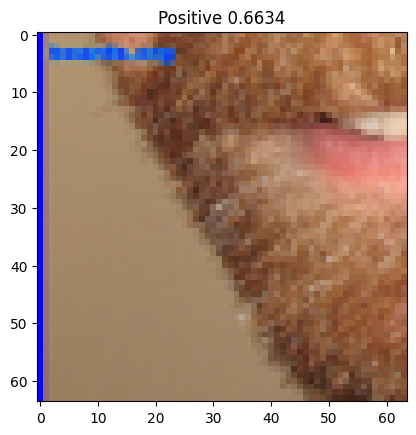

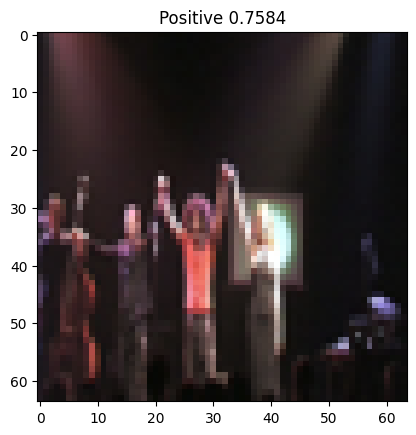

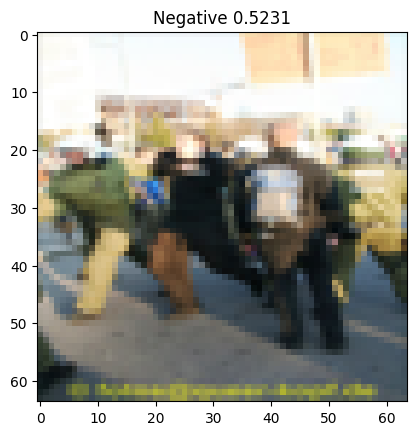

In [ ]:
for _ in range(3):
  random_idx = random.randint(0, len(data['input']))
  plot_image(data['output'][random_idx], 
             title=str(data['input'][random_idx]) + ' ' + str(data['confidence'][random_idx]))

#### Funcții utile pentru conversia din sentiment în număr și invers

In [ ]:
def sentiment_to_number(sentiment: str) -> int:
  if sentiment == 'Highly positive':
    return 2
  elif sentiment == 'Positive':
    return 1
  elif sentiment == 'Neutral':
    return 0
  elif sentiment == 'Negative':
    return -1
  elif sentiment == 'Highly negative':
    return -2
  else:
    raise ValueError('Invalid sentiment!')


def number_to_sentiment(num: int) -> str:
  if num == 2:
    return 'Highly positive'
  elif num == 1:
    return 'Positive'
  elif num == 0:
    return 'Neutral'
  elif num == -1:
    return 'Negative'
  elif num == -2:
    return 'Highly negative'
  else:
    raise ValueError('Invalid number!')

#### Rețeaua neuronală corespunzătoare discriminatorului

In [ ]:
import tensorflow as tf
from keras import layers


discriminator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        layers.Conv2D(IMAGE_SIZE[0], kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

#### Rețeaua neuronală corespunzătoare generatorului, primește 32 de input-uri random și încă 32 cu sentimentul corespunzător

In [ ]:
latent_dim = 64
sentiment_latent = 64

generator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(latent_dim + sentiment_latent,)),
        layers.Dense((IMAGE_SIZE[0] // 8) * (IMAGE_SIZE[1] // 8) * 128),
        layers.Reshape((IMAGE_SIZE[0] // 8, IMAGE_SIZE[1] // 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

#### Convertirea datelor într-un obiect de tip tf.data.Dataset și împărțirea acestora în batch-uri

In [ ]:
number_inputs = np.float32(np.asarray([[sentiment_to_number(sentiment)] * sentiment_latent 
                                      for sentiment in data['input']]) / 2.)
image_outputs = np.float32(np.asarray([x / 255. for x in data['output']]))
dataset = tf.data.Dataset.from_tensor_slices((number_inputs, image_outputs))
batch_size = 32
dataset = dataset.batch(batch_size)

#### Codul corespunzător GAN-ului, care la fiecare pas va genera și evalua câte o imagine, și va modifica ponderile rețelelor neuronale pe baza greșelilor

In [ ]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, inputs):
        sentiments, real_images = inputs
        batch_size = tf.shape(real_images)[0]
        
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        
        latent_inputs = tf.concat([random_latent_vectors, sentiments], axis=1)
        generated_images = self.generator(latent_inputs)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        latent_inputs = tf.concat([random_latent_vectors, sentiments], axis=1)

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(latent_inputs))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

#### Codul corespunzător callback-ului funcției de fit, pentru a vedea odată la câțiva pași progresul algoritmului

In [ ]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim: int, epochs: int):
        self.latent_dim = latent_dim
        self.epochs = epochs

    def _predict_images(self, num_img: int = 5, sentiment_numbers: list[int] = [-2, -1, 0, 1, 2]):
        random_latent_vectors = tf.random.normal(shape=(num_img, self.latent_dim))
        sentiment_numbers = [[number] * sentiment_latent for number in sentiment_numbers]
        sentiments = [number_to_sentiment(number[0]) for number in sentiment_numbers]
        sentiment_numbers = np.float32(np.asarray(sentiment_numbers) / 2.)
        latent_inputs = tf.concat([random_latent_vectors, sentiment_numbers], axis=1)
        generated_images = self.model.generator(latent_inputs)
        generated_images *= 255
        generated_images.numpy()
        return generated_images, sentiments

    def on_epoch_end(self, epoch: int, logs=None):
        if epoch % 10 == 0:
          generated_images, sentiments = self._predict_images()
          for i in range(5):
              img = tf.keras.utils.array_to_img(generated_images[i])
              img.save(f"generated/img_{epoch:03d}_{i}_{sentiments[i]}.png")
        elif epoch == self.epochs - 1:
          generated_images, sentiments = self._predict_images()
          for i in range(5):
              img = tf.keras.utils.array_to_img(generated_images[i])
              plot_image(img, title=sentiments[i])

#### Apelarea algoritmului pe setul de date realizat

Epoch 1/100
63/63 [==============================] - 34s 283ms/step - d_loss: 0.6773 - g_loss: 0.7809
Epoch 2/100
63/63 [==============================] - 15s 236ms/step - d_loss: 0.7107 - g_loss: 1.0251
Epoch 3/100
63/63 [==============================] - 15s 239ms/step - d_loss: 0.5526 - g_loss: 1.6489
Epoch 4/100
63/63 [==============================] - 15s 243ms/step - d_loss: 0.6398 - g_loss: 1.1057
Epoch 5/100
63/63 [==============================] - 16s 249ms/step - d_loss: 0.6401 - g_loss: 1.0005
Epoch 6/100
63/63 [==============================] - 16s 249ms/step - d_loss: 0.8590 - g_loss: 1.2473
Epoch 7/100
63/63 [==============================] - 16s 248ms/step - d_loss: 0.4680 - g_loss: 2.2425
Epoch 8/100
63/63 [==============================] - 16s 246ms/step - d_loss: 0.4417 - g_loss: 1.9692
Epoch 9/100
63/63 [==============================] - 16s 246ms/step - d_loss: 0.3691 - g_loss: 3.1778
Epoch 10/100
63/63 [==============================] - 16s 247ms/step - d_loss: 0.8

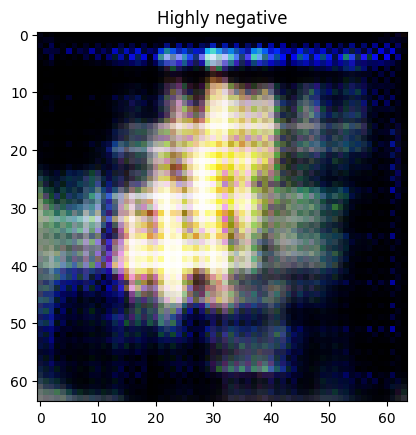

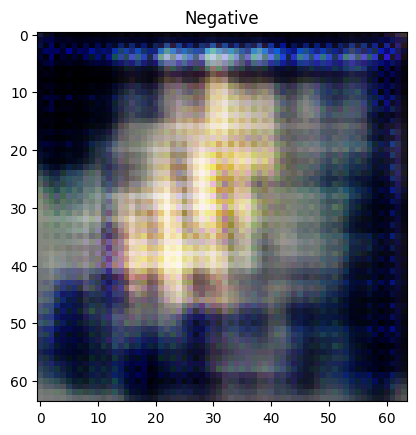

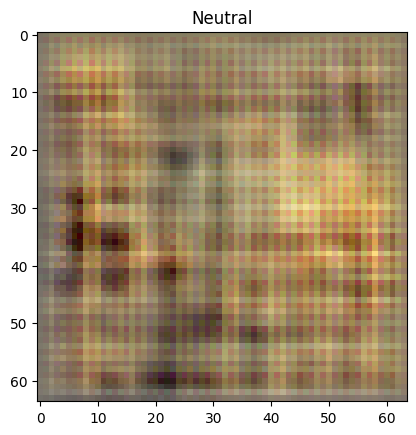

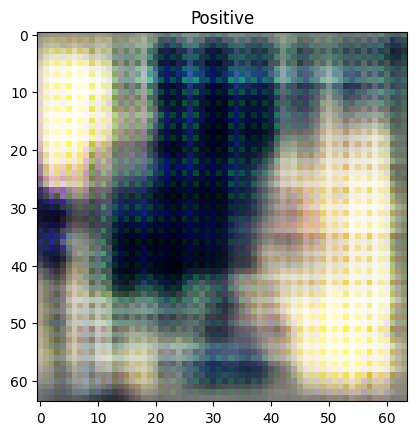

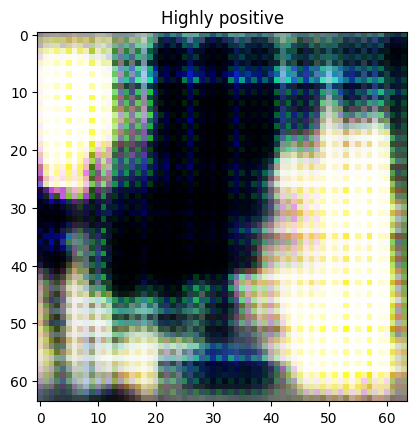

63/63 [==============================] - 17s 265ms/step - d_loss: 0.7483 - g_loss: 0.8450


In [ ]:
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=tf.keras.losses.BinaryCrossentropy())

gan.fit(dataset, epochs=epochs, 
        callbacks=[GANMonitor(latent_dim=latent_dim, epochs=epochs)])

#### Salvarea modelului

In [ ]:
import pickle


try:
    with open('models/algo3.pkl', 'wb') as f:
        pickle.dump(gan, f, pickle.HIGHEST_PROTOCOL)
except:
    pass

# Bibliografie

- https://en.wikipedia.org/wiki/Generative_adversarial_network
- https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter12_part05_gans.ipynb

In [ ]:
!zip -r /content/content.zip /content/data /content/generated /content/models

updating: content/data/ (stored 0%)
updating: content/data/image-sentiment-polarity.csv (deflated 75%)
updating: content/generated/ (stored 0%)
updating: content/generated/img_010_4_Highly positive.png (stored 0%)
updating: content/generated/img_020_3_Positive.png (stored 0%)
updating: content/generated/img_020_4_Highly positive.png (stored 0%)
updating: content/generated/img_020_2_Neutral.png (stored 0%)
updating: content/generated/img_040_4_Highly positive.png (stored 0%)
updating: content/generated/img_090_0_Highly negative.png (stored 0%)
updating: content/generated/img_010_0_Highly negative.png (stored 0%)
updating: content/generated/img_080_0_Highly negative.png (stored 0%)
updating: content/generated/img_070_2_Neutral.png (stored 0%)
updating: content/generated/img_060_3_Positive.png (stored 0%)
updating: content/generated/img_090_1_Negative.png (stored 0%)
updating: content/generated/img_030_0_Highly negative.png (stored 0%)
updating: content/generated/img_060_1_Negative.png (s